In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Путь к директориям и файлам

In [2]:
DATASET_PATH = 'C:/Users/Acer/Desktop/Поля/project_data_from_kaggle/project_data_from_kaggle/test.csv'
PREPARED_DATASET_PATH = 'C:/Users/Acer/Desktop/Поля/project_data_from_kaggle/project_data_from_kaggle/train.csv'

### Выгрузка данных

In [3]:
df_train = pd.read_csv(PREPARED_DATASET_PATH, sep = ',')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [4]:
df_test = pd.read_csv(DATASET_PATH, sep = ',')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


### Размеры датасетов

In [5]:
df_train.shape

(10000, 20)

In [6]:
df_test.shape

(5000, 19)

### Информация о тренировочном датасете

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Обработка пропусков

In [8]:
def replace_nulls(df, df_medians=None):
  if df_medians is None:
    df_medians = df
  
  column_names = ['LifeSquare', 'Healthcare_1']
  medians = df_medians[column_names].median()
  df[column_names] = df[column_names].fillna(medians)

  # return df # check yourself
  

replace_nulls(df_train)
replace_nulls(df_test, df_train)

In [9]:
df_train.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [10]:
df_test.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

### Замена буквенных значений

In [11]:
df_train_obj_features = df_train.select_dtypes(include='object')
df_train_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [12]:
df_train['Ecology_3'] = np.where((df_train.Ecology_3 == 'B'), 1, df_train.Ecology_3)
df_train['Ecology_3'] = np.where((df_train.Ecology_3 == 'A'), 0, df_train.Ecology_3)

In [13]:
df_train['Ecology_2'] = np.where((df_train.Ecology_2 == 'B'), 1, df_train.Ecology_2)
df_train['Ecology_2'] = np.where((df_train.Ecology_2 == 'A'), 0, df_train.Ecology_2)

In [14]:
df_train['Shops_2'] = np.where((df_train.Shops_2 == 'B'), 1, df_train.Shops_2)
df_train['Shops_2'] = np.where((df_train.Shops_2 == 'A'), 0, df_train.Shops_2)

In [15]:
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,900.0,0,0,1,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,900.0,0,6,1,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,1,1,52,10311,6,900.0,1,9,1,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,1,1,2,629,1,900.0,0,0,0,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,1,1,20,4386,14,900.0,1,5,1,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,1,1,47,8004,3,125.0,3,5,1,171842.411855


In [16]:
df_train['Ecology_3'] = df_train['Ecology_3'].astype('int16')
df_train['Ecology_2'] = df_train['Ecology_2'].astype('int16')
df_train['Shops_2'] = df_train['Shops_2'].astype('int16')

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int16  
 11  Ecology_3      10000 non-null  int16  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Обработка выборосов

In [18]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


#### Square

In [19]:
df_train.loc[df_train['Square'] < 17, 'Square'] = int(df_train['Square'].mean())

In [20]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.390689,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.839512,20.967582,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,0.000000,17.046188,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.804025,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.583675,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


#### LifeSquare

In [21]:
df_train.loc[df_train['LifeSquare'] == df_train['LifeSquare'].max(), 'LifeSquare'] = int(df_train['LifeSquare'].mean())

In [22]:
df_train.loc[df_train['LifeSquare'] < 14, 'LifeSquare'] = int(df_train['LifeSquare'].mean())

In [23]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.390689,36.228715,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.839512,20.967582,17.411107,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,0.000000,17.046188,14.057882,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.804025,27.817111,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.583675,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.423128,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


#### Kitchen

In [24]:
df_train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [25]:
df_train.loc[df_train['KitchenSquare'] > 200, 'KitchenSquare'] = int(df_train['KitchenSquare'].mean())

In [26]:
df_train.loc[df_train['KitchenSquare'] < 5, 'KitchenSquare'] = 0

In [27]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.390689,36.228715,5.60710,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.839512,20.967582,17.411107,5.43414,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,0.000000,17.046188,14.057882,0.00000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.804025,27.817111,0.00000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.583675,32.781260,6.00000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.423128,9.00000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,638.163193,123.00000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


### Floor

In [28]:
df_train['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
32.0        4
37.0        4
28.0        3
99.0        2
39.0        2
48.0        2
47.0        1
38.0        1
36.0        1
29.0        1
44.0        1
31.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

In [29]:
df_train.loc[df_train['HouseFloor'] == 116, 'HouseFloor'] = int(df_train['HouseFloor'].median())

In [30]:
df_train.loc[df_train['HouseFloor'] == 99, 'HouseFloor'] = 9

In [31]:
df_train['HouseFloor'].value_counts()

17.0     2331
9.0      1391
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
32.0        4
37.0        4
28.0        3
39.0        2
48.0        2
44.0        1
45.0        1
117.0       1
31.0        1
47.0        1
29.0        1
36.0        1
38.0        1
26.0        1
Name: HouseFloor, dtype: int64

#### Rooms

In [32]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [33]:
df_train.loc[df_train['Rooms'].isin([0, 10, 19]), 'Rooms'] = int(df_train['Rooms'].median())

In [34]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888800,56.390689,36.228715,5.60710,8.526700,12.59140,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.812096,20.967582,17.411107,5.43414,5.241148,6.66508,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,1.000000,17.046188,14.057882,0.00000,1.000000,0.00000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.804025,27.817111,0.00000,4.000000,9.00000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.583675,32.781260,6.00000,7.000000,13.00000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.423128,9.00000,12.000000,17.00000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,6.000000,641.065193,638.163193,123.00000,42.000000,117.00000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


#### HousFloor

In [35]:
df_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48., 117.])

In [36]:
df_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [37]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

In [38]:
floor_outliers = df_train[df_train['Floor'] > df_train['HouseFloor']].index
print(len(floor_outliers))

1610


In [39]:
df_train['Floor_error'] = 0
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Floor_error
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,1,11,3097,0,900.0,0,0,1,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,30,6207,1,1183.0,1,0,1,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,33,5261,0,240.0,3,1,1,282078.720850,0
3,2352,1,1.0,40.409907,32.781260,0.0,10,22.0,1977,0.007122,...,1,1,264,0,900.0,0,1,1,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,33,8667,2,900.0,0,6,1,343995.102962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,1,52,10311,6,900.0,1,9,1,119367.455796,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,...,1,2,629,1,900.0,0,0,0,199715.148807,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,1,20,4386,14,900.0,1,5,1,165953.912580,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,1,47,8004,3,125.0,3,5,1,171842.411855,0


In [40]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'Floor_error'] = df_train['Floor'] 
df_train.loc[df_train['Floor_error'] > 0, 'Floor'] = df_train['HouseFloor']
df_train.loc[df_train['Floor_error'] > 0, 'HouseFloor'] = df_train['Floor_error']

In [41]:
floor_outliers = df_train[df_train['Floor'] > df_train['HouseFloor']].index
print(len(floor_outliers))

0


In [42]:
df_train = df_train.drop('Floor_error', axis=1)

In [43]:
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,900.0,0,0,1,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850
3,2352,1,1.0,40.409907,32.781260,0.0,10.0,22.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,900.0,0,6,1,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981,0.300323,1,1,52,10311,6,900.0,1,9,1,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,1,1,2,629,1,900.0,0,0,0,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958,0.460556,1,1,20,4386,14,900.0,1,5,1,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,1,1,47,8004,3,125.0,3,5,1,171842.411855


#### HouseYear

In [44]:
df_train['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [45]:
df_train.loc[df_train['HouseYear'] == 4968, 'HouseYear'] = 1968

In [46]:
df_train.loc[df_train['HouseYear'] == 20052011, 'HouseYear'] = 2005

In [47]:
df_train.loc[df_train['HouseYear'] < 1910, 'HouseYear'] = df_train['HouseYear'].median()

In [48]:
df_train['HouseYear'].value_counts().sort_index()

1910      1
1912      2
1914      1
1916      1
1917      3
       ... 
2016    305
2017    308
2018    175
2019     79
2020     19
Name: HouseYear, Length: 95, dtype: int64

In [49]:
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,900.0,0,0,1,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850
3,2352,1,1.0,40.409907,32.781260,0.0,10.0,22.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,900.0,0,6,1,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981,0.300323,1,1,52,10311,6,900.0,1,9,1,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,1,1,2,629,1,900.0,0,0,0,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958,0.460556,1,1,20,4386,14,900.0,1,5,1,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,1,1,47,8004,3,125.0,3,5,1,171842.411855


In [50]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888800,56.390689,36.228715,5.60710,7.918200,13.549600,1984.865700,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.812096,20.967582,17.411107,5.43414,5.186386,5.873482,18.411517,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,1.000000,17.046188,14.057882,0.00000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.804025,27.817111,0.00000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.583675,32.781260,6.00000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.423128,9.00000,11.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,6.000000,641.065193,638.163193,123.00000,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [51]:
df_train['Id'] = df_train['Id'].astype(str)

### Отбор признаков

In [52]:
df_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [53]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

target = 'Price'

### Выделение целевой переменной

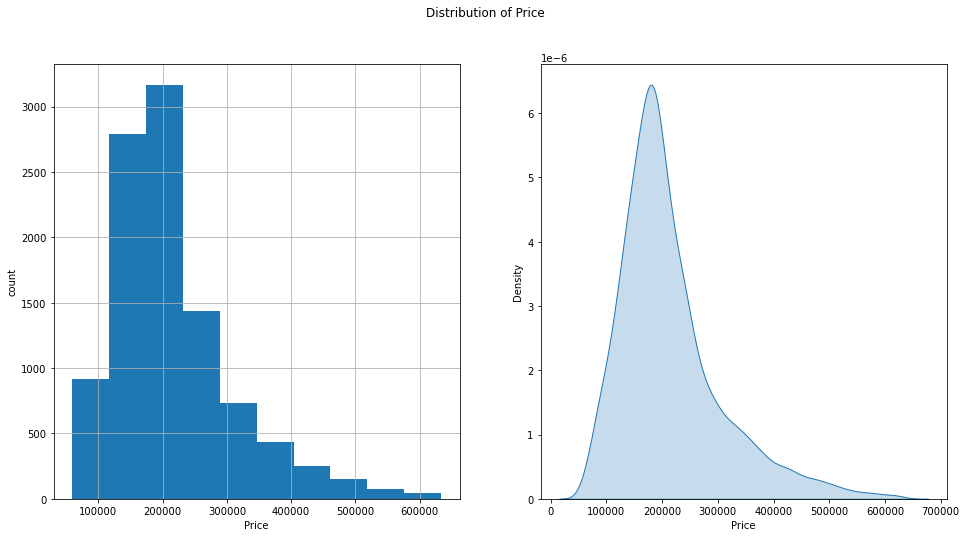

In [54]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df_train['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df_train['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [55]:
df_train = df_train[feature_names + [target]]
df_test = df_test[feature_names + ['Id']]
X = df_train[feature_names]
y = df_train[target]

In [56]:
X.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,3.0,115.027311,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,900.0,0,0,1
1,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1
2,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1
3,1.0,40.409907,32.781260,0.0,10.0,22.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1
4,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,900.0,0,6,1


In [57]:
y.head()

0    305018.871089
1    177734.553407
2    282078.720850
3    168106.007630
4    343995.102962
Name: Price, dtype: float64

In [58]:
y.describe

<bound method NDFrame.describe of 0       305018.871089
1       177734.553407
2       282078.720850
3       168106.007630
4       343995.102962
            ...      
9995    119367.455796
9996    199715.148807
9997    165953.912580
9998    171842.411855
9999    177685.627486
Name: Price, Length: 10000, dtype: float64>

### Разбиение на тестовый и тренировочный датасеты

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Корреляция важности признаков

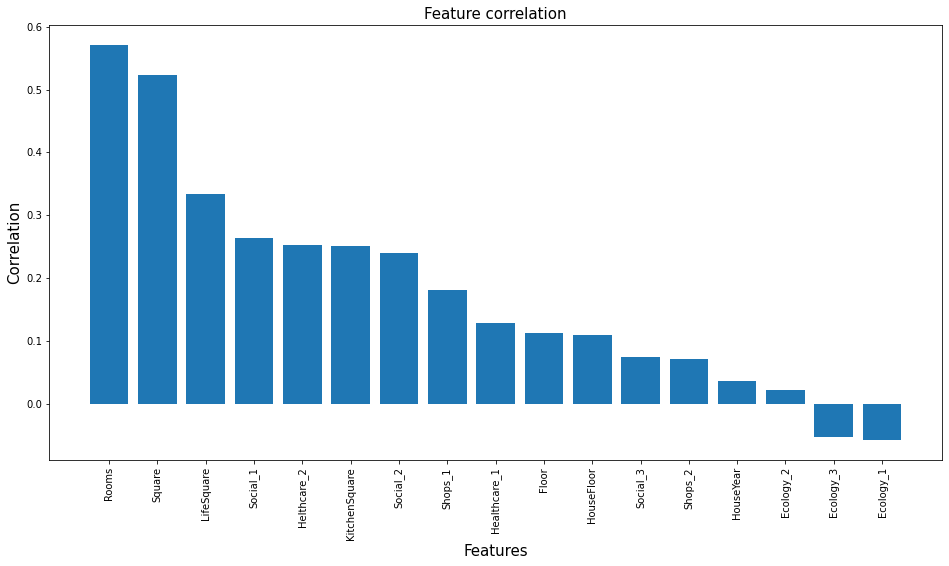

In [61]:
correlation = df_train.corrwith(df_train['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

### Обучение модели

In [62]:
model = CatBoostRegressor(
    silent=True,
    learning_rate=0.03,
    iterations=1200,
    eval_metric='R2',
    depth=10
)

model.fit(X, y)

cv_score = cross_val_score(
    model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

In [63]:
cv_score.mean()

0.7496949779339954

In [64]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,24.773207
12,Social_3,10.782990
7,Ecology_1,8.544457
11,Social_2,8.066684
6,HouseYear,7.683031
10,Social_1,6.890981
3,KitchenSquare,6.435450
5,HouseFloor,5.133224
13,Healthcare_1,4.137881
15,Shops_1,3.763285


### Обработка тестового датасета

#### Буквы

In [65]:
df_test_obj_features = df_test.select_dtypes(include='object')
df_test_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,A
2,B,B,B
3,B,B,B
4,B,B,B


In [66]:
df_test['Ecology_3'] = np.where((df_test.Ecology_3 == 'B'), 1, df_test.Ecology_3)
df_test['Ecology_3'] = np.where((df_test.Ecology_3 == 'A'), 0, df_test.Ecology_3)

In [67]:
df_test['Ecology_2'] = np.where((df_test.Ecology_2 == 'B'), 1, df_test.Ecology_2)
df_test['Ecology_2'] = np.where((df_test.Ecology_2 == 'A'), 0, df_test.Ecology_2)

In [68]:
df_test['Shops_2'] = np.where((df_test.Shops_2 == 'B'), 1, df_test.Shops_2)
df_test['Shops_2'] = np.where((df_test.Shops_2 == 'A'), 0, df_test.Shops_2)

In [69]:
df_test

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Id
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1036.0,1,1,1,4567
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,2,629,1,900.0,0,0,0,5925
2,2.0,59.463678,32.781260,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1,960
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,2,475,0,900.0,0,0,1,3848
4,1.0,53.837056,32.781260,1.0,8,17.0,1977,0.309479,1,1,35,7715,4,990.0,0,6,1,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,1,1,31,6119,4,900.0,1,2,1,10379
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,15,2787,2,520.0,0,7,1,16138
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,28,6533,1,1015.0,2,5,1,3912
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,33,7976,5,900.0,0,11,1,5722


In [70]:
df_test['Ecology_3'] = df_test['Ecology_3'].astype('int16')
df_test['Ecology_2'] = df_test['Ecology_2'].astype('int16')
df_test['Shops_2'] = df_test['Shops_2'].astype('int16')

In [71]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          5000 non-null   float64
 1   Square         5000 non-null   float64
 2   LifeSquare     5000 non-null   float64
 3   KitchenSquare  5000 non-null   float64
 4   Floor          5000 non-null   int64  
 5   HouseFloor     5000 non-null   float64
 6   HouseYear      5000 non-null   int64  
 7   Ecology_1      5000 non-null   float64
 8   Ecology_2      5000 non-null   int16  
 9   Ecology_3      5000 non-null   int16  
 10  Social_1       5000 non-null   int64  
 11  Social_2       5000 non-null   int64  
 12  Social_3       5000 non-null   int64  
 13  Healthcare_1   5000 non-null   float64
 14  Helthcare_2    5000 non-null   int64  
 15  Shops_1        5000 non-null   int64  
 16  Shops_2        5000 non-null   int16  
 17  Id             5000 non-null   int64  
dtypes: float

### Предсказание

In [72]:
df_test

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Id
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1036.0,1,1,1,4567
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,2,629,1,900.0,0,0,0,5925
2,2.0,59.463678,32.781260,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1,960
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,2,475,0,900.0,0,0,1,3848
4,1.0,53.837056,32.781260,1.0,8,17.0,1977,0.309479,1,1,35,7715,4,990.0,0,6,1,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,1,1,31,6119,4,900.0,1,2,1,10379
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,15,2787,2,520.0,0,7,1,16138
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,28,6533,1,1015.0,2,5,1,3912
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,33,7976,5,900.0,0,11,1,5722


In [73]:
submit = pd.read_csv('C:/Users/Acer/Desktop/Поля/project_data_from_kaggle/project_data_from_kaggle/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [74]:
predict = pd.DataFrame()
predict['Id'] = df_test['Id'].copy()

df_test.set_index('Id', inplace=True)
df_test = df_test[feature_names]

In [75]:
y_predict = model.predict(df_test)

In [76]:
submit['Price'] = y_predict
submit.to_csv('./PPantel_predictions.csv', index=False, encoding='utf-8', sep=',')

In [77]:
submit.head()

,Id,Price
0,4567,160793.013087
1,5925,120433.060641
2,960,150878.588329
3,3848,105733.136899
4,746,199799.982546
